In [ ]:
import io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import urllib
from skimage.transform import resize
from matplotlib.image import imread
import os
from IPython.display import display
from skimage import io as io_url
import cv2
import numpy as np
from PIL import Image

In [ ]:
# Create image widgets
image3_spatial = widgets.Image(format='png', width=500, height=500, description='Spatial')
image3_freq    = widgets.Image(format='png', width=500, height=500, description='Frequency')
sidebyside     = widgets.HBox([image3_spatial, image3_freq])

# Create slider/select widgets
slider_inner   = widgets.FloatSlider(value=0,      min=0, max=1,      step=0.01, description='Inner radius')
slider_outer   = widgets.FloatSlider(value=1.44/2, min=0, max=1.44/2, step=0.01, description='Outer radius')

buf            = io.BytesIO()

orig_img = io_url.imread('https://img2.zergnet.com/2309662_300.jpg')
orig_img = np.mean(orig_img, -1)

x = np.fft.fftfreq(orig_img.shape[0]);
y = np.fft.fftfreq(orig_img.shape[1]);

xv, yv = np.meshgrid(x, y)
xv = np.fft.fftshift(xv)
yv = np.fft.fftshift(yv)

In [ ]:
def filter_frequency(orig_img, mask):
  """
  You need to remove frequency based on the given mask.
  Params:
    orig_img: numpy image
    mask: same shape with orig_img indicating which frequency hold or remove
  Output:
    f_img: frequency image after applying mask
    img: image after applying mask
  """
  # You need to implement this function
  # 1. Transform using fft2
  fft_img = np.fft.fft2(orig_img)
  # 2. Shift frequency coefs to center using fftshift
  fft_img_shifted = np.fft.fftshift(fft_img)
  # 3. Filter in frequency domain using the given mask
  fft_img_filtered = fft_img_shifted * mask
  # 4. Shift frequency coefs back using ifftshift
  fft_img_filtered_shifted = np.fft.ifftshift(fft_img_filtered)
  # 5. Invert transform using ifft2
  img = np.abs(np.fft.ifft2(fft_img_filtered_shifted))

  return np.abs(fft_img_filtered), img

In [ ]:
def on_value_change3(change):
    mask = (np.sqrt(xv**2 + yv**2) < slider_outer.value) & \
           (np.sqrt(xv**2 + yv**2) >= slider_inner.value)
    mask = np.float32(mask)

    fimg, img = filter_frequency(orig_img, mask)
    buf.seek(0)
    tmp = PIL.Image.fromarray(255*img/(img.max()+0.0001))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_spatial.value = buf.getvalue()

    buf.seek(0)
    tmp = PIL.Image.fromarray(255*np.log(0.0001*fimg + 1))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_freq.value = buf.getvalue()

In [ ]:
slider_inner.observe(on_value_change3, names='value')
slider_outer.observe(on_value_change3, names='value')

on_value_change3(0)

display(sidebyside)
display(slider_inner)
display(slider_outer)

FloatSlider(value=0.65, description='Inner radius', max=1.0, step=0.01)

FloatSlider(value=0.72, description='Outer radius', max=0.72, step=0.01)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 1. 0.]
 ...
 [0. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

In [ ]:
def read_img(img_path, img_size=(512, 512)):
  """
    + Đọc ảnh
    + Chuyển thành grayscale
    + Thay đổi kích thước ảnh thành img_size
  """
  img = cv2.imread(img_path, 0)
  img = cv2.resize(img, img_size)
  return img


def create_hybrid_img(img1, img2, r):
  """
  Create hydrid image
  Params:
    img1: numpy image 1
    img2: numpy image 2
    r: radius that defines the filled circle of frequency of image 1. Refer to the homework title to know more.
  """
  # You need to implement the function
  # 1. Transform using fft2
  fft_img1 = np.fft.fft2(img1)
  fft_img2 = np.fft.fft2(img2)

  # 2. Shift frequency coefs to center using fftshift
  fft_img1_shifted = np.fft.fftshift(fft_img1)
  fft_img2_shifted = np.fft.fftshift(fft_img2)

  # 3. Create a mask based on the given radius (r) parameter
  mask_1 = np.zeros_like(fft_img1_shifted)
  h, w = mask_1.shape[:2]
  cen_h, cen_w = int(h / 2), int(w / 2)
  y, x = np.ogrid[-cen_h : h - cen_h,
                  -cen_w : w - cen_w]
  mask_1[x * x + y * y <= r * r] = 1
  mask_2 = (1 - mask_1)

  # 4. Combine frequency of 2 images using the mask
  fft_hybrid_shifted = fft_img1_shifted * mask_1 + fft_img2_shifted * mask_2

  # 5. Shift frequency coefs back using ifftshift
  fft_hybrid = np.fft.ifftshift(fft_hybrid_shifted)

  # 6. Invert transform using ifft2
  return np.abs(np.fft.ifft2(fft_hybrid))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


(-0.5, 511.5, 511.5, -0.5)

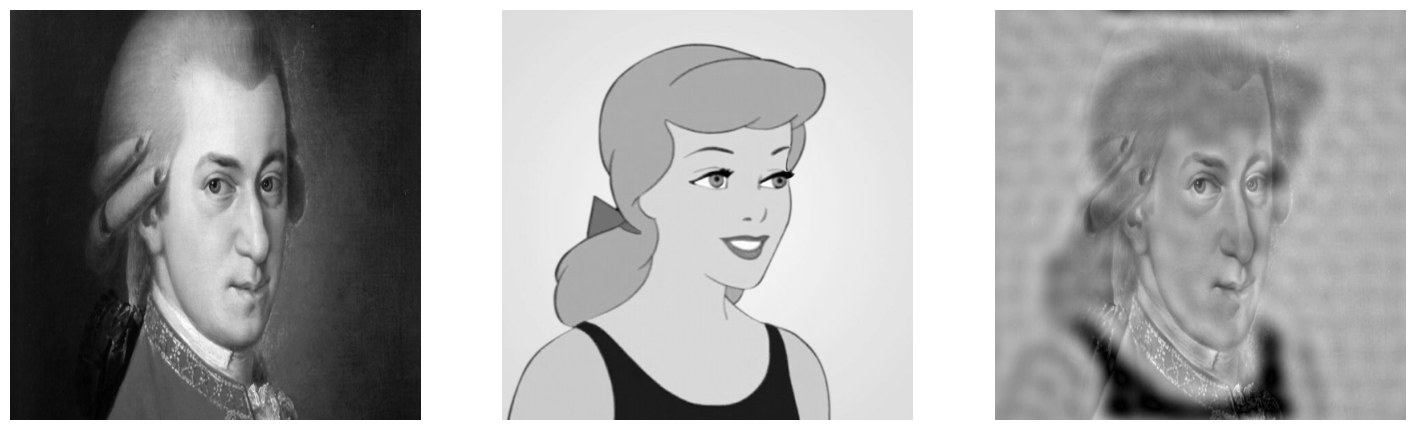

In [ ]:
image_1_path = "mozart.png" # <-- need to change
image_2_path = "cinderella.png" # <-- need to change
img_1 = read_img(image_1_path)
img_2 = read_img(image_2_path)
hybrid_img = create_hybrid_img(img_2, img_1, 14)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 15))
axes[0].imshow(img_1, cmap="gray")
axes[0].axis("off")
axes[1].imshow(img_2, cmap="gray")
axes[1].axis("off")
axes[2].imshow(hybrid_img, cmap="gray")
axes[2].axis("off")